# 3. Performance guidelines.

In this notebook we will describe the most important guidelines when programming code for NVIDIA GPU cards.

We will consider the following aspects of optimizing CUDA kernels:
- memory access patterns: *memory coalescing* for the best throughput,
- control flow: how code branching can affect the performance,
- multiprocessor occupancy: experimenting with different block sizes.

You will also learn how profiling metrics can tell us where the performance issues are.

This notebooks will mostly base on content available in the [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html). 

## 3.1. Memory access patterns.

According to [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html):
> For devices of compute capability 6.0 or higher, the requirements can be summarized quite easily: the concurrent accesses of the threads of a warp will coalesce into a number of transactions equal to the number of **32-byte transactions** necessary to service all of the threads of the warp.

This means that the number of useful memory accesses done by a kernel, and thus its performance, largely depends on the memory access pattern it does.

Our objective is to implement a GPU kernel that only loads **useful** data from global memory, that will then be used in the calculations. We can achieve this with **coalesced memory accesses**.

To achive **coalesced memory accesses** in our kernel, we need to meet the following conditions:
- the number of threads per block is a multiple of 32 threads,
- sequential threads in a warp access memory that is sequential.


For example, the `add_vectors_gpu` and `convolve_gpu` CUDA functions satisfy the above conditions:
- the number of threads per block was equal 256,
- adjacent threads were reading adjacent memory areas, e.g. thread `i` read the `a[i]` and `b[i]`, and thread `i+1` read `a[i+1]` and `b[i+1]`.  


We will discuss below what are the reasons for both of the conditions.

### 3.1.1. Impact of misaligned accesses.

According to [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html):
> The number of threads per block should be a multiple of 32 threads, because this provides optimal computing efficiency and facilitates coalescing.

Let's recall that CUDA warp reads global memory by using a sequence of **32-byte** segments transactions.


**Example**

As an example, we will consider here:
- `add_vectors_gpu` function,
- number of threads in block is equal 13 (each thread reads 4 byte from array `a`, so we read 13 x 4-byte = 52 bytes in a single block). 

Let's take a look what memory accesses will be performed by thread block 0, 1, etc.

_Block 0_

- reads memory area [0, 52), size: 52 bytes (13 x 4-byte floats)

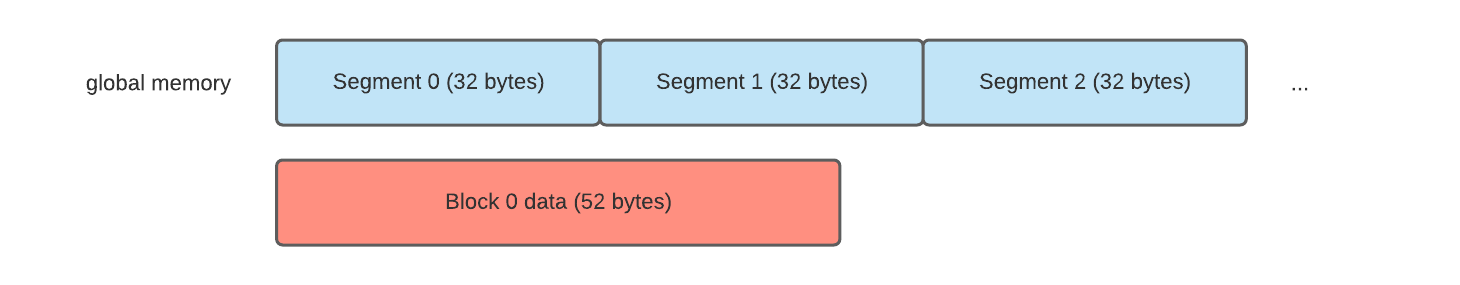

- This requires the transfer of two segments, as the block data is located in the segment 0 and segment 1. Thus we are trasferring 2 x 32 bytes of data. 
- However only 52 bytes will be used (81%). 


**Block 1**

- Reads memory area [52, 104), size: 52 bytes.

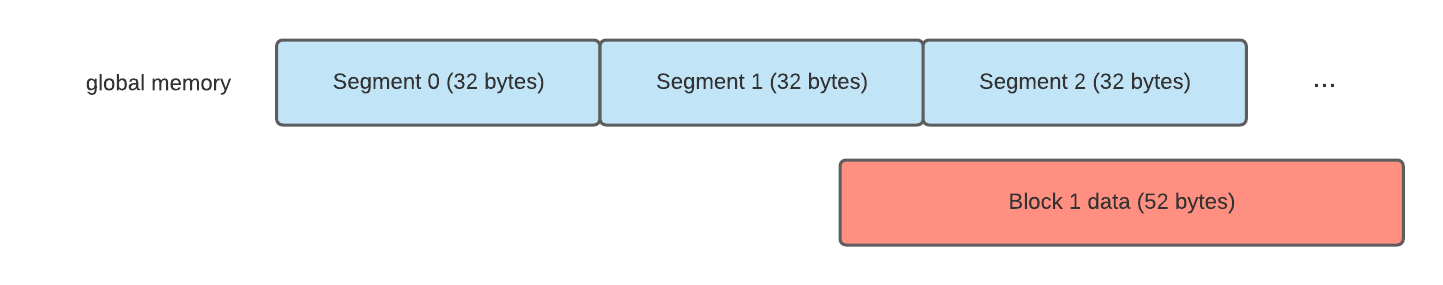

- This requires the transfer of three segments, as the block data is located in the segments 1, 2 and 3. Thus we are trasferring 3 x 32 bytes of data. 
- However only 52 bytes will be used (54%). 


**And so on...**


As we can see, we are transfer a large amount of (theoretically) useless data.

**Experiments**

Let's see if there is any observable performance difference between scripts using 256 and 261 threads in a **block**:

In [ ]:
%%writefile 3_1_1_aligned.py
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

block_size = 256

add_vectors_src = open("3_add_vectors.cc").read()
add_vectors_gpu_kernel = cp.RawKernel(code=add_vectors_src, name="add_vectors")


def add_vectors_gpu(a, b):
    assert len(a) == len(b)
    c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)
    a_gpu = cp.asarray(a)
    b_gpu = cp.asarray(b)
    grid_size = math.ceil(len(a)/block_size)

    # Invoke the kernel.
    add_vectors_gpu_kernel(grid=(grid_size, ), block=(block_size, ), args=(c_gpu, a_gpu, b_gpu, len(a_gpu)))
    # Get the result.
    c = c_gpu.get()

gpu_short_course.tests.benchmark_add_vectors(add_vectors_gpu)

In [ ]:
! nvprof --trace gpu python 3_1_1_aligned.py

In [ ]:
%%writefile 3_1_1_misaligned.py
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

block_size = 261

add_vectors_src = open("3_add_vectors.cc").read()
add_vectors_gpu_kernel = cp.RawKernel(code=add_vectors_src, name="add_vectors")


def add_vectors_gpu(a, b):
    assert len(a) == len(b)
    c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)
    a_gpu = cp.asarray(a)
    b_gpu = cp.asarray(b)
    grid_size = math.ceil(len(a)/block_size)

    # Invoke the kernel.
    add_vectors_gpu_kernel(grid=(grid_size, ), block=(block_size, ), args=(c_gpu, a_gpu, b_gpu, len(a_gpu)))
    # Get the result.
    c = c_gpu.get()

gpu_short_course.tests.benchmark_add_vectors(add_vectors_gpu)

In [ ]:
! nvprof --trace gpu python 3_1_1_misaligned.py

The difference in performance of the aligned and misaligned versions is rather minor (on some devices even negligible).

Why? 

In this particular case, adjacent warps **reuse the cached data** their neighbors fetched. According to the [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html): 

> So while the impact is still evident it is not as large as we might have expected. It would have been more so if adjacent warps had not exhibited such a high degree of reuse of the over-fetched cache lines.

Still, **setting a block size to a multiple of warp size** is a good rule of thumb: it facilitates coalescing, and (as we will discuss later), helps to avoid wasting multiprocessor computation time on under-populated warps.

### 3.1.2. Impact of strided accesses.

A non-unit-strided global memory accesses may impact effective memory bandwidth. 

We say that GPU kernel performs a unit-strided memory access, if threads with successive identifiers read the data from successive memory areas, in other words, the following access pattern is respected:

```
x = data[(some custom offset) + threadIdx.x]
```


The degradation in performance can be especially apparent when working with multidimensional arrays - the choice of the axis, along which choosing a specific operation is performed, can affect effective bandwidth.

**Example**

Let's consider a 1D convolution along one of the axes of a 2D array.


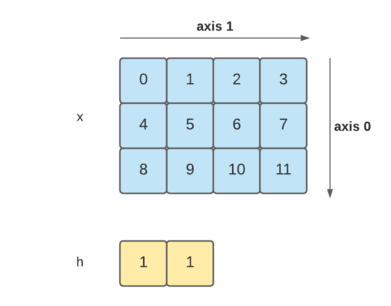

NumPy stores arrays in row-major order, so the above array is actually kept in computer's memory as a following 1D array:

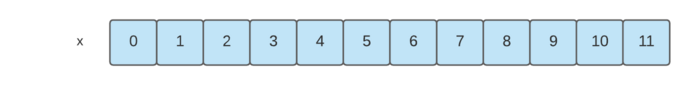

Let's consider doing convolution along axis 0 and 1.


**Convolve along axis 1**:


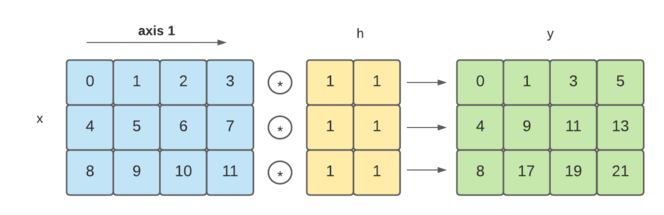

The first output row is calculated in the following way:


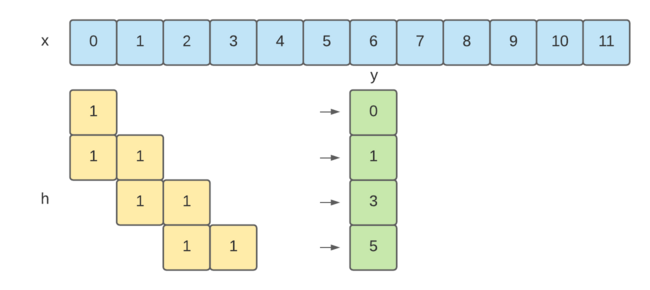

`y[0]` `y[1]`, `y[2]` and `y[3]` are computed by threads with `threadIdx.x` equal `0`, `1`, `2` and `3`, respectively.

This translates to the following memory readings:


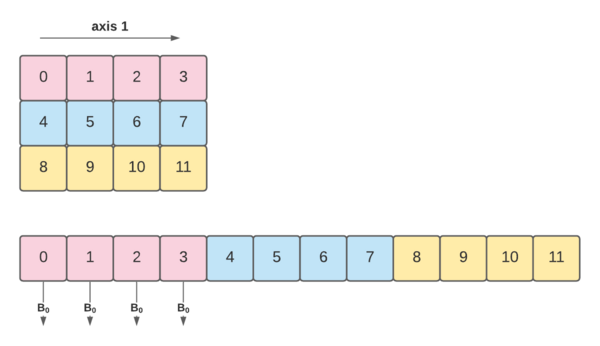

If we assume that the colors red, blue and yellow represent successive segments in the GPU memory, all readings for the computation of the first row fit in one block.

How it will look like for the case when we are doing convolution along axis 0?

**Convolve along axis 0**:

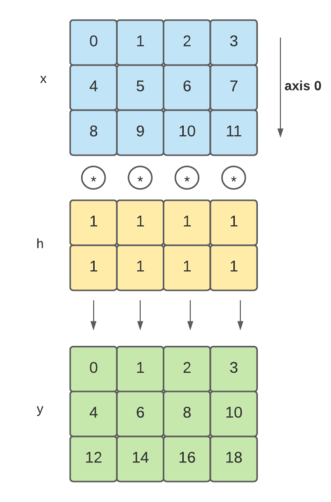

The first output column is calculated in the following way:


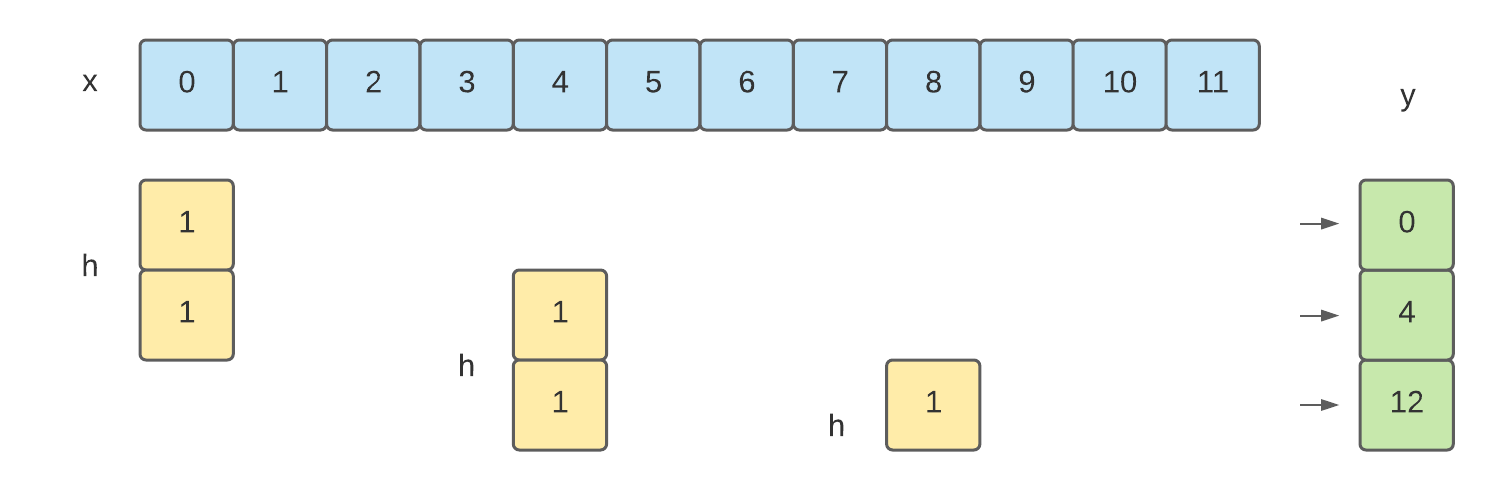




`y[0]` `y[1]`, and `y[2]` are computed by threads with `threadIdx.x` equal `0`, `1` and `2` respectively.

This translates to the following memory readings:


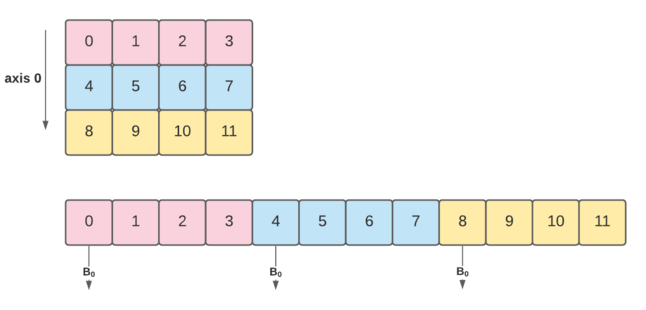

Of course, the above examples have been simplified for the sake of clarity of the description.

Anyway, as we can see in the above example, the stride is expected to be much larger for the convolution along axis 0. 

Will it impact the bandwidth?

**Experiments**

Let's do the experiments to verify the impact of the stride on the kernel's performance.

In [ ]:
%%writefile 3_1_2_convolve_strided_access.py

import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

convolve_axis0_gpu_kernel_src = open("3_convolve1d_axis0.cc").read()
convolve_axis0_gpu_kernel = cp.RawKernel(code=convolve_axis0_gpu_kernel_src, name="convolve1d_axis0")

convolve_axis1_gpu_kernel_src = open("3_convolve1d_axis1.cc").read()
convolve_axis1_gpu_kernel = cp.RawKernel(code=convolve_axis1_gpu_kernel_src, name="convolve1d_axis1")


def convolve_axis0_gpu(x, h):
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    height, width = x.shape
    n = len(h)
    o = int(math.ceil(n/2)-1)
    block = (32, 32)
    block_h, block_w = block
    grid = (math.ceil(width/block_w), math.ceil(height/block_h))
    convolve_axis0_gpu_kernel(grid, block, args=(y, x, h, height, width, n, o))
    return y.get()


def convolve_axis1_gpu(x, h):
    y = cp.empty(shape=x.shape, dtype=np.float32) 
    x = cp.asarray(x.astype(np.float32))
    h = cp.asarray(h.astype(np.float32))
    height, width = x.shape
    n = len(h)
    o = int(math.ceil(n/2)-1)
    block = (32, 32)
    block_h, block_w = block
    grid = (math.ceil(width/block_w), math.ceil(height/block_h))
    convolve_axis1_gpu_kernel(grid, block, args=(y, x, h, height, width, n, o))
    return y.get()


gpu_short_course.run_convolve_2d_input(convolve_axis0_gpu, axis=0)
gpu_short_course.run_convolve_2d_input(convolve_axis1_gpu, axis=1)

Traditionally, let's test the output produced by implemented functions.

In [ ]:
! python 3_1_2_convolve_strided_access.py --mode test

And now benchmark it.

In [ ]:
! nvprof --trace gpu python 3_1_2_convolve_strided_access.py --mode benchmark quiet=1

On my GPU (Nvidia GeForce Titan X), convolution along axis 1 takes much less time than along axis 0.

We can use profiler metrics to verify what memory access efficiency for both cases we have:

In [ ]:
! nvprof --metrics gld_efficiency,gst_efficiency python 3_1_2_convolve_strided_access.py --mode benchmark n=1 quiet=1

# 3.2. Control flow: how code branching affects the performance.

Due to SIMT architecture of the CUDA multiprocessors, it is recommended to avoid different paths within the same warp.

According to [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html):
> Flow control instructions (if, switch, do, for, while) can significantly affect the instruction throughput by causing threads of the same warp to diverge; that is, to follow different execution paths. If this happens, the different execution paths must be executed separately; this increases the total number of instructions executed for this warp.

**Example**

Let's implement the following function:

```
y[i] = r[i]*a[i] + b[i]
```

where `r[i] = i mod 8`.

We can implement it in one of the two ways:
1. the **easy** way: directly by definition,
2. the **overcomplicated** way: by doing a sequence of `if ... else if ... else if ... else` for each different value of $i \mod 8$.

In [28]:
%%writefile 3_2_control_flow.py

import math
import numpy as np
import cupy as cp
import gpu_short_course.tests


block_size = 256

add_vectors_mod8_simple_src = open("3_add_vectors_mod8_simple.cc").read()
add_vectors_mod8_simple_kernel = cp.RawKernel(code=add_vectors_mod8_simple_src, name="add_vectors_mod8_simple")

add_vectors_mod8_overcomplicated_src = open("3_add_vectors_mod8_overcomplicated.cc").read()
add_vectors_mod8_overcomplicated_kernel = cp.RawKernel(code=add_vectors_mod8_overcomplicated_src, name="add_vectors_mod8_overcomplicated")


def add_vectors_mod8_simple(a, b):
    assert len(a) == len(b)
    c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)
    a_gpu = cp.asarray(a)
    b_gpu = cp.asarray(b)
    grid_size = math.ceil(len(a)/block_size)
    # Invoke the kernel.
    add_vectors_mod8_simple_kernel(grid=(grid_size, ), block=(block_size, ), args=(c_gpu, a_gpu, b_gpu, len(a_gpu)))
    # Get the result.
    c = c_gpu.get()
    
    
def add_vectors_mod8_overcomplicated(a, b):
    assert len(a) == len(b)
    c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)
    a_gpu = cp.asarray(a)
    b_gpu = cp.asarray(b)
    grid_size = math.ceil(len(a)/block_size)
    # Invoke the kernel.
    add_vectors_mod8_overcomplicated_kernel(grid=(grid_size, ), block=(block_size, ), args=(c_gpu, a_gpu, b_gpu, len(a_gpu)))
    # Get the result.
    c = c_gpu.get()


gpu_short_course.tests.benchmark_add_vectors(add_vectors_mod8_simple)
gpu_short_course.tests.benchmark_add_vectors(add_vectors_mod8_overcomplicated)

Overwriting 3_2_control_flow.py


Let's check how much time does it take to execute each of the kernel:

In [29]:
! nvprof --trace gpu python 3_2_control_flow.py

==1067== NVPROF is profiling process 1067, command: python 3_2_control_flow.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0067 seconds (+/- 0.0465), median: 0.0020
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0020 seconds (+/- 0.0001), median: 0.0020
==1067== Profiling application: python 3_2_control_flow.py
==1067== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   60.98%  135.87ms       400  339.69us  338.73us  353.87us  [CUDA memcpy HtoD]
                   31.03%  69.134ms       200  345.67us  332.27us  375.53us  [CUDA memcpy DtoH]
                    5.72%  12.752ms       100  127.52us  126.40us  129.00us  add_vectors_mod8_overcomplicated
                    2.27%  5.0619ms       100  50.618us  49.601us  51.9

Let's also measure `branch_efficiency` metric defined as a:
> Ratio of non-divergent branches to total branches expressed as percentage.

In [30]:
! nvprof --metrics branch_efficiency python 3_2_control_flow.py

==1100== NVPROF is profiling process 1100, command: python 3_2_control_flow.py
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0167 seconds (+/- 0.0409), median: 0.0125
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0125 seconds (+/- 0.0002), median: 0.0125
==1100== Profiling application: python 3_2_control_flow.py
==1100== Profiling result:
==1100== Metric result:
Invocations                               Metric Name                        Metric Description         Min         Max         Avg
Device "GeForce GTX TITAN X (0)"
    Kernel: add_vectors_mod8_simple
        100                         branch_efficiency                         Branch Efficiency     100.00%     100.00%     100.00%
    Kernel: add_vectors_mod8_overcomplicated
        100                         branch_efficiency

Of course, the above example has been artificially complicated just to show the effect of complex kernel logic on the kernel's performance.

# Exercise 3.3. Multiprocessor occupancy: thread block size.

Recall that:
> The number of threads per block should be a **multiple of 32 threads**, because this provides optimal computing efficiency and facilitates coalescing.

[CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html) also gives some other suggestions how to choose the proper number of threads per block:

> There are many such factors involved in selecting block size, and inevitably some experimentation is required. However, a few rules of thumb should be followed:
> 1. Threads per block should be **a multiple of warp size** to avoid wasting computation on under-populated warps and to facilitate coalescing.
> 2. A **minimum of 64 threads** per block should be used, and only if there are multiple concurrent blocks per multiprocessor.
> 3. Between **128 and 256 threads** per block is a good initial range for experimentation with different block sizes.
> 4. Use several smaller thread blocks rather than one large thread block per multiprocessor if latency affects performance. This is particularly beneficial to kernels that frequently call __syncthreads().

### Example

Let's mesure `add_vectors` occupancy for a different number of threads:


In [31]:
%%writefile 3_3_occupancy.py

import sys
import math
import numpy as np
import cupy as cp
import gpu_short_course.tests

block_size = int(sys.argv[1])

add_vectors_src = open("3_add_vectors.cc").read()
add_vectors_gpu_kernel = cp.RawKernel(code=add_vectors_src, name="add_vectors")


def add_vectors_gpu(a, b):
    assert len(a) == len(b)
    c_gpu = cp.empty(shape=a.shape, dtype=a.dtype)
    a_gpu = cp.asarray(a)
    b_gpu = cp.asarray(b)
    grid_size = math.ceil(len(a)/block_size)

    # Invoke the kernel.
    add_vectors_gpu_kernel(grid=(grid_size, ), block=(block_size, ), args=(c_gpu, a_gpu, b_gpu, len(a_gpu)))
    # Get the result.
    c = c_gpu.get()

gpu_short_course.tests.benchmark_add_vectors(add_vectors_gpu)

Writing 3_3_occupancy.py


In [32]:
! nvprof --trace gpu python 3_3_occupancy.py 16

==1438== NVPROF is profiling process 1438, command: python 3_3_occupancy.py 16
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0071 seconds (+/- 0.0502), median: 0.0021
==1438== Profiling application: python 3_3_occupancy.py 16
==1438== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   56.53%  67.985ms       200  339.92us  338.63us  353.39us  [CUDA memcpy HtoD]
                   31.26%  37.598ms       100  375.98us  337.93us  1.1442ms  [CUDA memcpy DtoH]
                   12.20%  14.678ms       100  146.78us  146.69us  147.52us  add_vectors
No API activities were profiled.


According to NVIDIA documentation, `achieved_occupancy` measures:
> Ratio of the average active warps per active cycle to the maximum number of warps supported on a multiprocessor.

In [33]:
! nvprof --metrics achieved_occupancy python 3_3_occupancy.py 16

==1467== NVPROF is profiling process 1467, command: python 3_3_occupancy.py 16
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0200 seconds (+/- 0.0400), median: 0.0160
==1467== Profiling application: python 3_3_occupancy.py 16
==1467== Profiling result:
==1467== Metric result:
Invocations                               Metric Name                        Metric Description         Min         Max         Avg
Device "GeForce GTX TITAN X (0)"
    Kernel: add_vectors
        100                        achieved_occupancy                        Achieved Occupancy    0.168891    0.179867    0.169734


In [34]:
! nvprof --trace gpu python 3_3_occupancy.py 256
! nvprof --metrics achieved_occupancy python 3_3_occupancy.py 256

==1495== NVPROF is profiling process 1495, command: python 3_3_occupancy.py 256
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0067 seconds (+/- 0.0470), median: 0.0020
==1495== Profiling application: python 3_3_occupancy.py 256
==1495== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   61.76%  68.015ms       200  340.07us  338.89us  353.23us  [CUDA memcpy HtoD]
                   33.66%  37.061ms       100  370.61us  334.47us  1.0353ms  [CUDA memcpy DtoH]
                    4.58%  5.0450ms       100  50.450us  49.665us  51.457us  add_vectors
No API activities were profiled.
==1522== NVPROF is profiling process 1522, command: python 3_3_occupancy.py 256
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce 

In [35]:
! nvprof --trace gpu python 3_3_occupancy.py 1024
! nvprof --metrics achieved_occupancy python 3_3_occupancy.py 1024

==1572== NVPROF is profiling process 1572, command: python 3_3_occupancy.py 1024
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeForce GTX TITAN X'
Benchmarking the function, please wait...
Benchmark result: 
Average processing time: 0.0066 seconds (+/- 0.0460), median: 0.0020
==1572== Profiling application: python 3_3_occupancy.py 1024
==1572== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   62.31%  67.935ms       200  339.68us  338.67us  347.37us  [CUDA memcpy HtoD]
                   33.09%  36.076ms       100  360.76us  331.66us  1.0735ms  [CUDA memcpy DtoH]
                    4.60%  5.0171ms       100  50.170us  49.345us  51.649us  add_vectors
No API activities were profiled.
==1599== NVPROF is profiling process 1599, command: python 3_3_occupancy.py 1024
GPU:0: b'GeForce GTX TITAN X'
GPU:1: b'GeForce GTX TITAN X'
GPU:2: b'GeForce GTX TITAN X'
GPU:3: b'GeFor

Finding the right number of threads per block requires some experimentation, but generally 128 or 256 threads is a good starting point.

# References

- [CUDA Best Practices Guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html). 
- [Efficient Matrix Transpose in CUDA C/C++ (NVIDIA Devblog Post)](https://developer.nvidia.com/blog/efficient-matrix-transpose-cuda-cc/)
- [How to access global memory efficiently (NVIDIA Devblog Post)](https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/)